In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.pothook_analysis_lib import *
from torchvision.transforms import ToTensor, ToPILImage, Pad, Compose
from torchvision.utils import make_grid
from core.utils.CNN_scorers import resize_and_pad_tsr


In [2]:
# set path variabels
pd_key="expriment_meta_data_df"
proc_data_root = r"N:\PonceLab\Users\Alireza\insilico_experiments\unit_inflation_smal_set"
rawdata_root = r"N:\PonceLab\Users\Alireza\insilico_experiments\unit_inflation_smal_set\unit_inflation_small_set_081723"
save_root = os.path.join(proc_data_root, "results")
os.makedirs(save_root, exist_ok=True)
concated_df_path = os.path.join(proc_data_root, "metadata_dfs_preprocessed_concated")
metadata_df_cosine = pd.read_hdf(os.path.join(concated_df_path, "meta_data_df.h5"), key=pd_key)
metadata_df_cosine.loc[metadata_df_cosine['modif_unit_id'].isnull(), 'exp_stage'] = 'reconstruction'

In [26]:
metadata_df_cosine.head()


''''metadata_df_cosine[(metadata_df_cosine['exp_stage'] == 'reconstruction') &\
                    (metadata_df_cosine['trget_imge_name'] == 'invar_2') &\
                    (metadata_df_cosine['similarity_metric'] == 'cosine') &\
                    (metadata_df_cosine['output_type'] == 'best_gen_imgs') &\
                    (metadata_df_cosine['sub_pop_type'] == 'most')]

metadata_df_cosine[(metadata_df_cosine['exp_stage'] == 'inflation_from_scratch') &\
                    (metadata_df_cosine['trget_imge_name'] == 'invar_2') &\
                    (metadata_df_cosine['similarity_metric'] == 'cosine') &\
                    (metadata_df_cosine['output_type'] == 'best_gen_imgs') &\
                    (metadata_df_cosine['sub_pop_type'] == 'most')]'''

output_type trget_imge_name similarity_metric   
1692246778_1239114               target_img         invar_2            cosine  \
1692246778_9404949     target_img_RF_masked         invar_2            cosine   
1692246796_2012170          generation_data         invar_2            cosine   
1692246796_8812071            best_gen_imgs         invar_2            cosine   
1692246796_2767363  best_gen_imgs_RF_masked         invar_2            cosine   

                    pop_size  pop_resampling_id gan_name   
1692246778_1239114       128                  0      fc6  \
1692246778_9404949       128                  0      fc6   
1692246796_2012170       128                  0      fc6   
1692246796_8812071       128                  0      fc6   
1692246796_2767363       128                  0      fc6   

                              layer_name layer_short net_name img_size   
1692246778_1239114  [.features.Conv2d10]       conv5  alexnet     None  \
1692246778_9404949  [.features.Conv2d10]       conv5  alexnet     None   
1692246796_2012170  [.features.Conv2d10]       conv5  alexnet     None   
1692246796_8812071  [.features.Conv2d10]       conv5  alexnet     None   
1692246796_2767363  [.features.Conv2d10]       conv5  alexnet     None   

                   pading_size     input_size     score   
1692246778_1239114    (40, 40)  (3, 227, 227)       NaN  \
1692246778_9404949    (40, 40)  (3, 227, 227)       NaN   
1692246796_2012170    (40, 40)  (3, 227, 227)  0.931941   
1692246796_8812071    (40, 40)  (3, 227, 227)  0.931941   
1692246796_2767363    (40, 40)  (3, 227, 227)  0.931941   

                                                         pop_unit_idx   
1692246778_1239114  {'.features.Conv2d10': [20702, 9717, 41996, 39...  \
1692246778_9404949  {'.features.Conv2d10': [20702, 9717, 41996, 39...   
1692246796_2012170  {'.features.Conv2d10': [20702, 9717, 41996, 39...   
1692246796_8812071  {'.features.Conv2d10': [20702, 9717, 41996, 39...   
1692246796_2767363  {'.features.Conv2d10': [20702, 9717, 41996, 39...   

                   sub_pop_type gen_rerun_id modif_unit_idx modif_unit_id   
1692246778_1239114         most         None           None          None  \
1692246778_9404949         most         None           None          None   
1692246796_2012170         most            0           None          None   
1692246796_8812071         most            0           None          None   
1692246796_2767363         most            0           None          None   

                         exp_stage   
1692246778_1239114  reconstruction  \
1692246778_9404949  reconstruction   
1692246796_2012170  reconstruction   
1692246796_8812071  reconstruction   
1692246796_2767363  reconstruction   

                                                            data_root  
1692246778_1239114  N:\PonceLab\Users\Alireza\insilico_experiments...  
1692246778_9404949  N:\PonceLab\Users\Alireza\insilico_experiments...  
1692246796_2012170  N:\PonceLab\Users\Alireza\insilico_experiments...  
1692246796_8812071  N:\PonceLab\Users\Alireza\insilico_experiments...  
1692246796_2767363  N:\PonceLab\Users\Alireza\insilico_experiments...

In [3]:
image_name_list = metadata_df_cosine["trget_imge_name"].unique()
image_name_list

array(['invar_2', 'ecoset_49', 'invar_1_flipped'], dtype=object)

In [5]:
# let make a latent codes space
# clustering the units based on the similarity of the activity pattern of the units in the last step, and print samples
from core.utils.CNN_scorers import resize_and_pad_tsr
from core.utils.GAN_utils import upconvGAN
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

image_name_list = metadata_df_cosine["trget_imge_name"].unique()
# perpare the the image_name_list
image_name_list = [image_name_list[1], image_name_list[0], image_name_list[2]]
layer_short= "conv5"
similarity_metric_list = ["MSE", "cosine"]
smpling_types = ["most", 'random']
pop_size = 128
gen_rerun_id_max = metadata_df_cosine["gen_rerun_id"].max()
pop_resampling_max = metadata_df_cosine["pop_resampling_id"].max()

target_type = "target_img_RF_masked"
gen_image_type = "best_gen_imgs_RF_masked"

pro_image_type = "best_gen_imgs"
pop_act_evol_type = "popul_act_evol"
inflation_tragectory_type = "best_in_each_gen_imgs_RF_masked"

inflation_evol_data_type = "generation_data"

# set foint size
plt.rcParams.update({'font.size': 21})

# Load or create your matrix
metric_list = ['euclidean', 'cosine']  # Example metric in ['euclidean', 'correlation', 'cosine']

import numpy as np
from scipy.cluster import hierarchy
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

RF_treshold = 2
pop_resampling_id = 0
num_of_sample_to_print = 16
save_path_root = os.path.join(save_root, f"inflation_profile_{pop_size}_v3")

# load rsetive filed mask
rf_obj = np.load(os.path.join(proc_data_root, "rf_filters", f"{layer_short}_{pop_size}.npz"))

# setup the  GAN
gan_name = 'fc6'
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
Ngens = 100
num_gen = 100
##
sampling_type = smpling_types[0]
similarity_metric = 'MSE'
image_name = image_name_list[1]
gen_rerun_id = 0
##

actmat_mtx = np.zeros((pop_size, pop_size))
sample_batch_size = 100
units_proto_evol_codes_o = list()
units_proto_evol_score_o = np.zeros((pop_size, num_gen))
units_proto_evol_act_mat_list_o = list()
units_proto_evol_list_o = list()
units_proto_evol_unit_id_o = list()
units_proto_evol_gen_id_o = list()
units_proto_evol_gen_rerun_id_o = list()
for ni in range(pop_size):
    for gen_rerun_id in range(gen_rerun_id_max + 1):
        inflation_evol_data = load_npz(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                output_type=inflation_evol_data_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
        actmat_all = inflation_evol_data['actmat_all']
        generations = inflation_evol_data['generations']
        scores_all = inflation_evol_data['scores_all']
        best_code_all = inflation_evol_data['best_codes']
        units_proto_evol_codes_o.append(best_code_all)
        units_proto_evol_unit_id_o.append(np.ones(num_gen) * ni)
        units_proto_evol_gen_id_o.append(np.arange(num_gen))
        units_proto_evol_gen_rerun_id_o.append(np.ones(num_gen) * gen_rerun_id)
        units_proto_evol_act_mat = np.zeros((num_gen, pop_size))
        for gi in range(num_gen):
            scores_gen = scores_all[generations == gi]
            actmat_gen = actmat_all[generations == gi, :]
            max_score_index = scores_gen.argmax()
            units_proto_evol_score_o[ni, gi] = scores_gen[max_score_index]
            units_proto_evol_act_mat[gi, :] = actmat_gen[max_score_index, :]
        # get cell prototypes
        unit_prtoptype = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                        output_type=pro_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                        similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                                        pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
        units_proto_evol_list_o.append(unit_prtoptype)
        #units_proto_evol_act_mat_list_o.append(units_proto_evol_act_mat[:, ::-1])      
        units_proto_evol_act_mat_list_o.append(units_proto_evol_act_mat)        

In [6]:
target_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                        output_type=target_type, pop_size=pop_size,
                        similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                        pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')

recontruction_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                        output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                        similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                        pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')

pop_act_evol = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                        output_type=pop_act_evol_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                        similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                        pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')
inflation_evol_data = load_npz(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                        output_type=inflation_evol_data_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                        similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                        pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')    
recon_best_code_all = inflation_evol_data['best_codes']
recon_generations = inflation_evol_data['generations']
recon_scores_all = inflation_evol_data['scores_all']
recon_actmat_all = inflation_evol_data['actmat_all']
recon_act_mat_o = np.zeros((num_gen, pop_size))
for gi in range(num_gen):
    scores_gen = recon_scores_all[recon_generations == gi]
    actmat_gen = recon_actmat_all[recon_generations == gi, :]
    max_score_index = scores_gen.argmax()
    recon_act_mat_o[gi, :] = actmat_gen[max_score_index, :]
''''
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(ToPILImage()(target_image))
ax.set_title(f"target image for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
ax.axis("off")
plt.tight_layout()
plt.show()
# save the figure 

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(ToPILImage()(recontruction_image))
ax.set_title(f"recontrted image for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
ax.axis("off")
plt.tight_layout()
# save the figure 
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(ToPILImage()(pop_act_evol))
ax.set_title(f"population activity evolution for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
ax.axis("off")
plt.tight_layout()
# save the figure
plt.show()'''


'\'\nfig, ax = plt.subplots(figsize=(5, 5))\nax.imshow(ToPILImage()(target_image))\nax.set_title(f"target image for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")\nax.axis("off")\nplt.tight_layout()\nplt.show()\n# save the figure \n\nfig, ax = plt.subplots(figsize=(5, 5))\nax.imshow(ToPILImage()(recontruction_image))\nax.set_title(f"recontrted image for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")\nax.axis("off")\nplt.tight_layout()\n# save the figure \nplt.show()\n\nfig, ax = plt.subplots(figsize=(5, 5))\nax.imshow(ToPILImage()(pop_act_evol))\nax.set_title(f"population activity evolution for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")\nax.axis("off")\nplt.tight_layout()\n# save the figure\nplt.show()'

In [10]:
'''# let filip the order of the recon_act_mat in axis 1
recon_act_mat = recon_act_mat_o[:, ::-1]
units_proto_evol_score = units_proto_evol_score_o[::-1, :]
# let filip the order of the units_proto_evol_codes list in axis 0
units_proto_evol_codes = [x for x in reversed(units_proto_evol_codes_o)]
units_proto_evol_unit_id = [x for x in reversed(units_proto_evol_unit_id_o)]
units_proto_evol_gen_id = [x for x in reversed(units_proto_evol_gen_id_o)]
units_proto_evol_list = [x for x in reversed(units_proto_evol_list_o)]
units_proto_evol_act_mat_list = [x for x in reversed(units_proto_evol_act_mat_list_o)]'''

recon_act_mat = recon_act_mat_o
units_proto_evol_score = units_proto_evol_score_o
# let filip the order of the units_proto_evol_codes list in axis 0
units_proto_evol_codes = units_proto_evol_codes_o
units_proto_evol_unit_id = units_proto_evol_unit_id_o
units_proto_evol_gen_id = units_proto_evol_gen_id_o
units_proto_evol_list = units_proto_evol_list_o
units_proto_evol_act_mat_list = units_proto_evol_act_mat_list_o
units_proto_evol_gen_rerun_id = units_proto_evol_gen_rerun_id_o



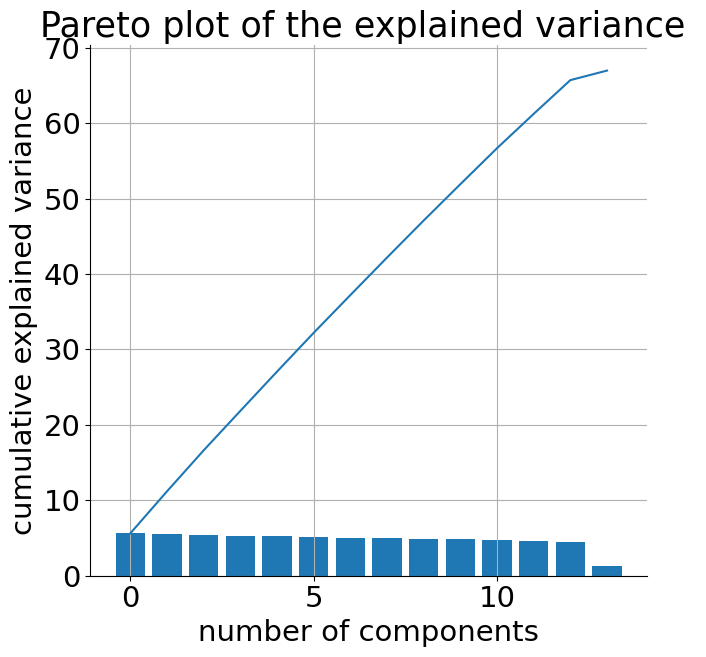

In [65]:
# here we will finf the PCA of the latent space which is units_proto_evol_codes and make a paretp plot 
# of the explenation of the variance of the forsrt 10 components

from sklearn.decomposition import PCA
from scipy import stats
# let concatenate the lists
num_of_units_to_cat = 7*2
units_proto_evol_codes_cat = np.concatenate(units_proto_evol_codes[:num_of_units_to_cat], axis=0)
'''# let z score each unit codes before concatenating
units_proto_evol_codes_zscore = list()
for unit_code in units_proto_evol_codes[:num_of_units_to_cat]:
    # z score by scipy
    unit_code_zscore = stats.zscore(unit_code, axis=0)
    units_proto_evol_codes_zscore.append(unit_code_zscore)
units_proto_evol_codes_cat = np.concatenate(units_proto_evol_codes_zscore, axis=0)'''
units_proto_evol_unit_id_cat = np.concatenate(units_proto_evol_unit_id[:num_of_units_to_cat], axis=0)
units_proto_evol_gen_id_cat = np.concatenate(units_proto_evol_gen_id[:num_of_units_to_cat], axis=0)
units_proto_evol_act_mat_cat = np.concatenate(units_proto_evol_act_mat_list[:num_of_units_to_cat], axis=0)
units_proto_evol_gen_rerun_id_o = np.concatenate(units_proto_evol_gen_rerun_id[:num_of_units_to_cat], axis=0)


n_components = num_of_units_to_cat
pca_latent_space = PCA(n_components=n_components)
PCA_score = pca_latent_space.fit_transform(units_proto_evol_codes_cat)
# let plot the pareto plot of the ecplained variance of the first 10 components
plt.figure(figsize=(7, 7))
plt.plot(np.cumsum(pca_latent_space.explained_variance_ratio_*100))
plt.bar(np.arange(n_components), pca_latent_space.explained_variance_ratio_*100)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Pareto plot of the explained variance ')
plt.grid()
plt.tight_layout()

# let apply this PCA transformation the we get for latent space to the recon_best_code_all
recon_best_code_all_PC = pca_latent_space.transform(recon_best_code_all)


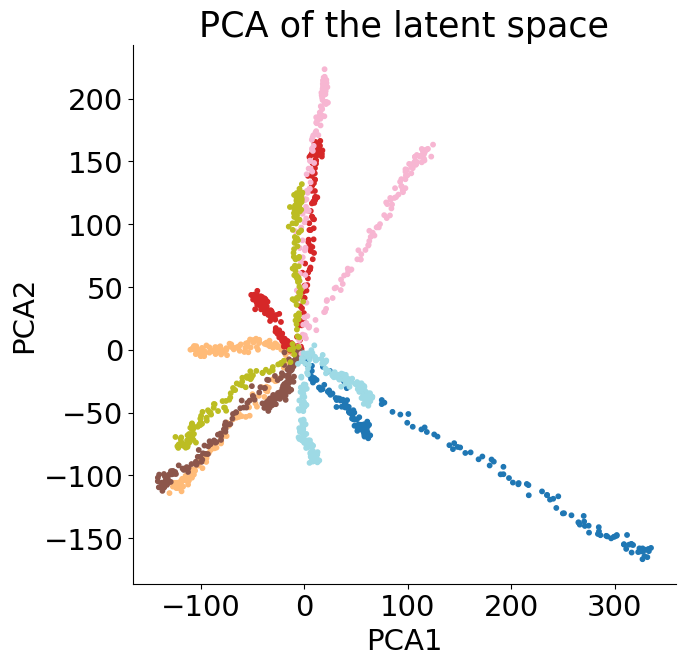

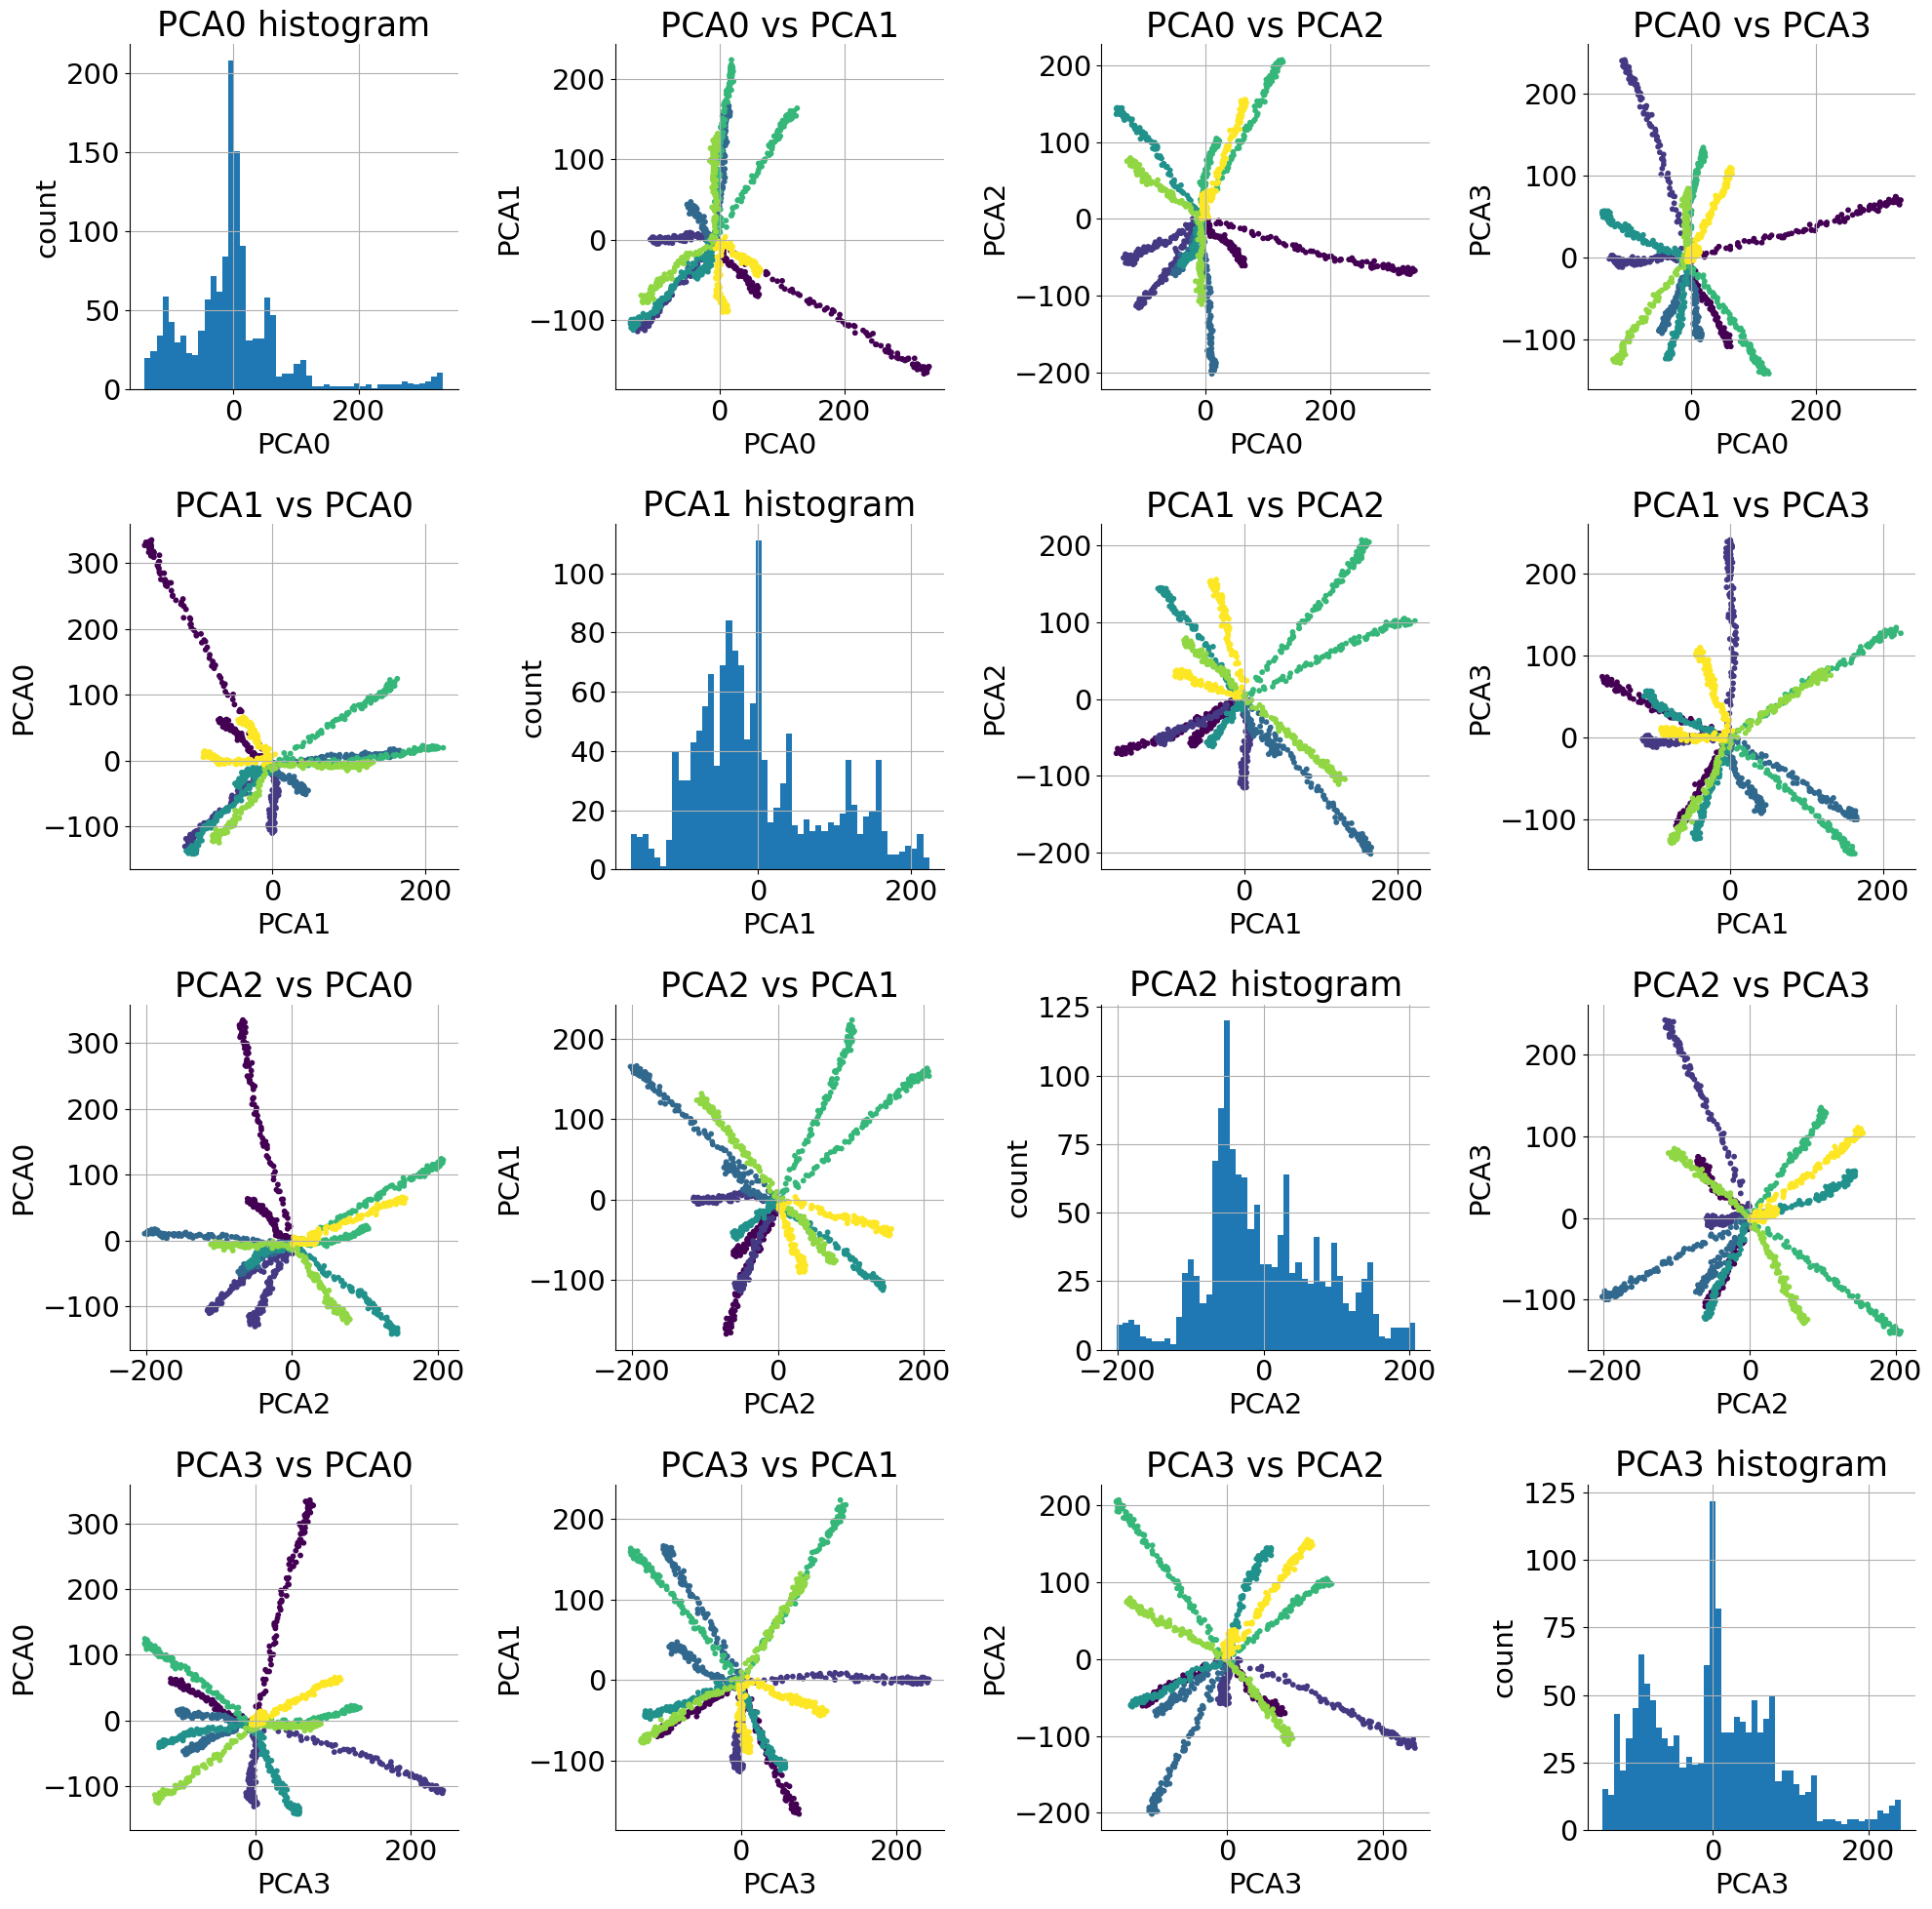

In [66]:
# let plot the first 2 components of the PCA and give the color of the points based on the unit index
plt.figure(figsize=(7, 7))
selected_unit = 0
plt.scatter(PCA_score[:, 0], PCA_score[:,1], s=10, c=units_proto_evol_unit_id_cat, cmap='tab20')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of the latent space')

# let print girp of 4 first components
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
selected_unit = 0
for i in range(4):
    for j in range(4):
        if i != j:
            axs[i, j].scatter(PCA_score[:, i], PCA_score[:, j], s=10, c=units_proto_evol_unit_id_cat, cmap='viridis')
            # add the reconstrction trajectory
            #axs[i, j].scatter(recon_best_code_all_PC[:, 0], recon_best_code_all_PC[:, 1], c=recon_act_mat[:, selected_unit], facecolors='none', s=10)
            axs[i, j].set_xlabel(f'PCA{i}')
            axs[i, j].set_ylabel(f'PCA{j}')
            axs[i, j].set_title(f'PCA{i} vs PCA{j}')
            axs[i, j].grid()
        else:
            # let plot the histogram of the component
            axs[i, j].hist(PCA_score[:, i], bins=50)
            axs[i, j].set_xlabel(f'PCA{i}')
            axs[i, j].set_ylabel('count')
            axs[i, j].set_title(f'PCA{i} histogram')
            axs[i, j].grid()
plt.tight_layout()

Text(0.5, 1.0, 'PCA of the latent space')

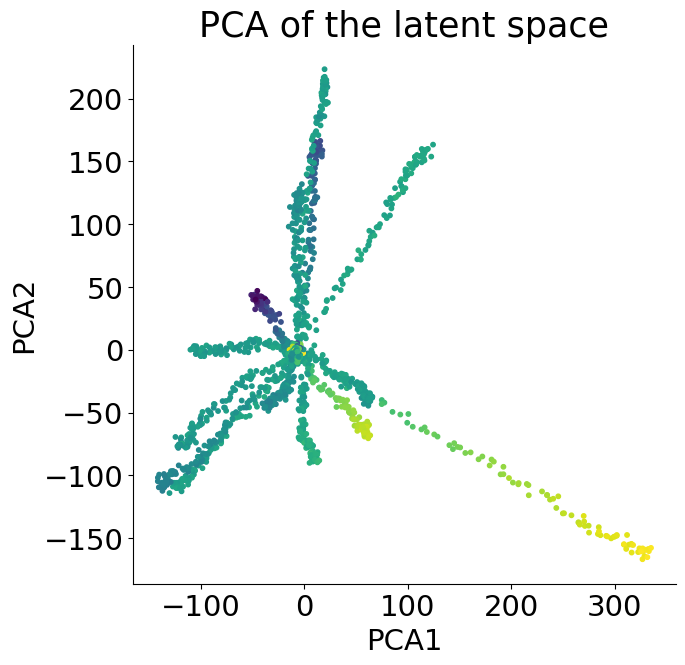

In [67]:
# let plot the first 2 components of the PCA and give the color of the points based on the unit index
plt.figure(figsize=(7, 7))
selected_unit = 0
plt.scatter(PCA_score[:, 0], PCA_score[:,1], s=10, c=units_proto_evol_act_mat_cat[:, selected_unit], cmap='viridis')
# plot the reconstrction trajectory with empty circles
plt.scatter(recon_best_code_all_PC[:, 0], recon_best_code_all_PC[:, 1], c=recon_act_mat[:, selected_unit], facecolors='none', s=10)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of the latent space')

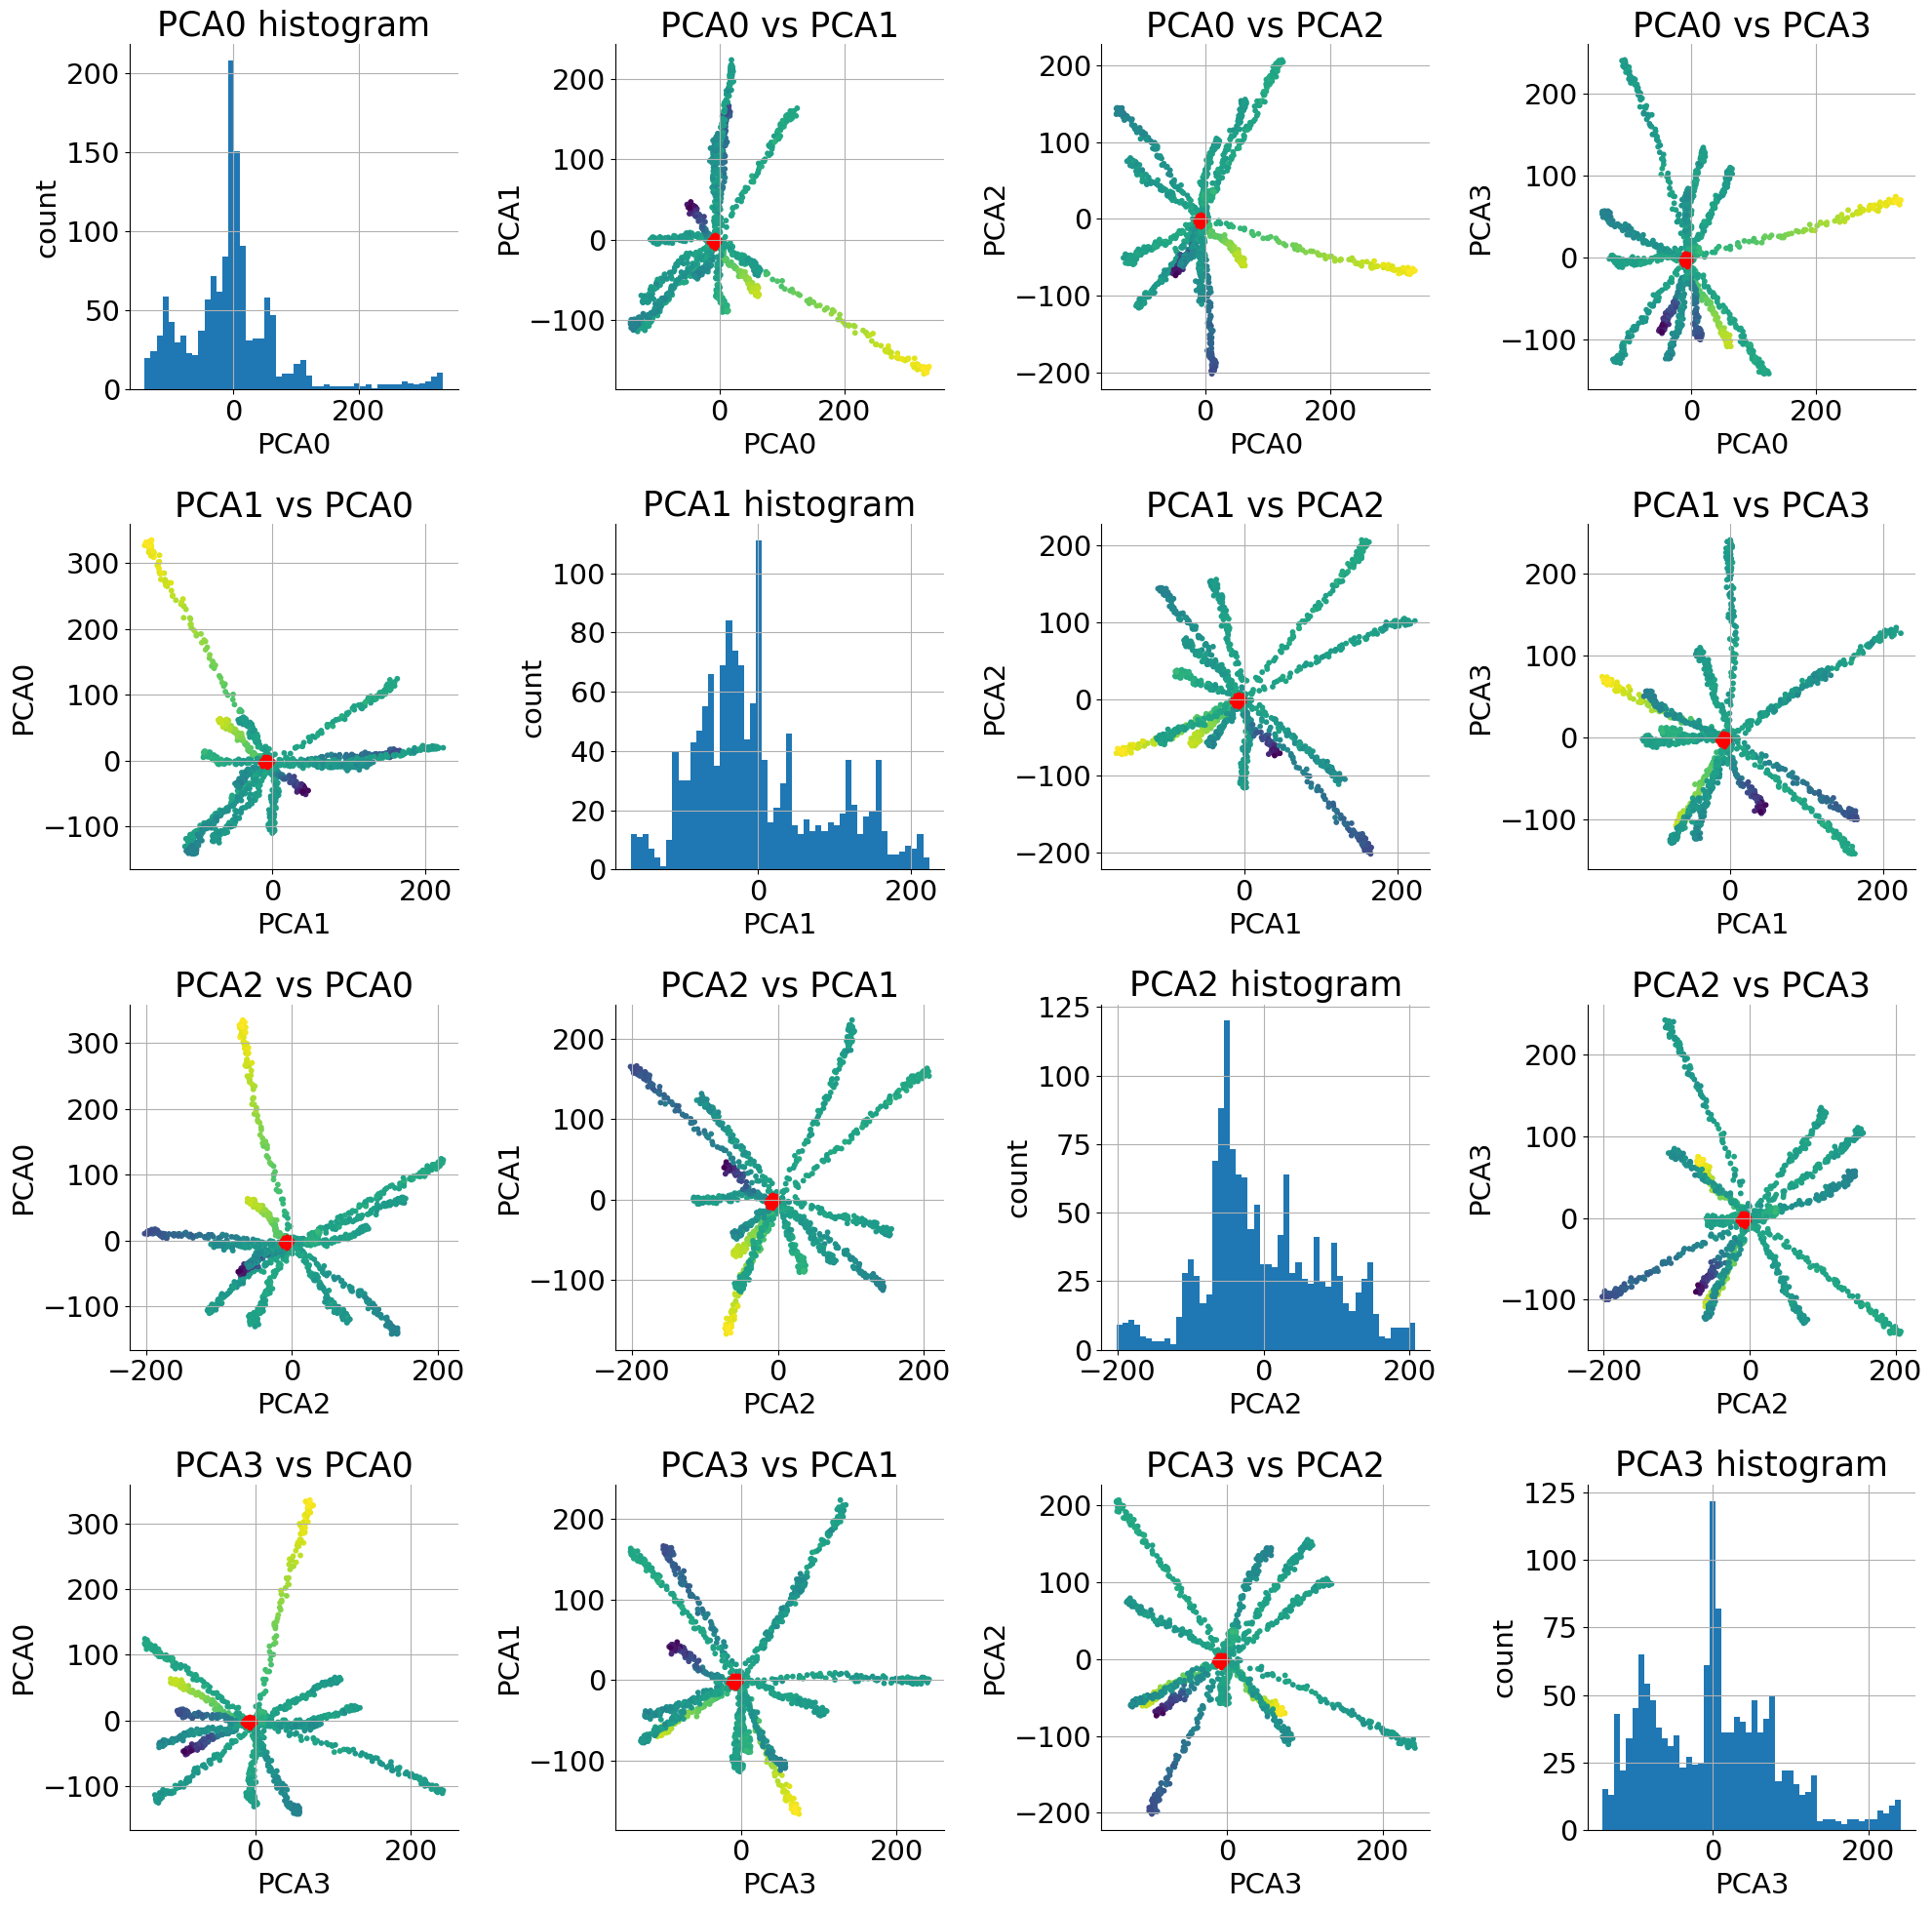

In [68]:
# let print girp of 4 first components
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
selected_unit = 0
for i in range(4):
    for j in range(4):
        if i != j:
            axs[i, j].scatter(PCA_score[:, i], PCA_score[:, j], s=10, c=units_proto_evol_act_mat_cat[:, selected_unit], cmap='viridis')
            # add the reconstrction trajectory
            #axs[i, j].scatter(recon_best_code_all_PC[:, 0], recon_best_code_all_PC[:, 1], c=recon_act_mat[:, selected_unit], facecolors='none', s=10)
            axs[i, j].scatter(recon_best_code_all_PC[:, 0], recon_best_code_all_PC[:, 1], c='r', facecolors='none', s=10)
            axs[i, j].set_xlabel(f'PCA{i}')
            axs[i, j].set_ylabel(f'PCA{j}')
            axs[i, j].set_title(f'PCA{i} vs PCA{j}')
            axs[i, j].grid()
        else:
            # let plot the histogram of the component
            axs[i, j].hist(PCA_score[:, i], bins=50)
            axs[i, j].set_xlabel(f'PCA{i}')
            axs[i, j].set_ylabel('count')
            axs[i, j].set_title(f'PCA{i} histogram')
            axs[i, j].grid()
plt.tight_layout()

Text(0.5, 1.0, 'correlation of the distance and the activity of\n the last generation  r2=0.00 p=0.00')

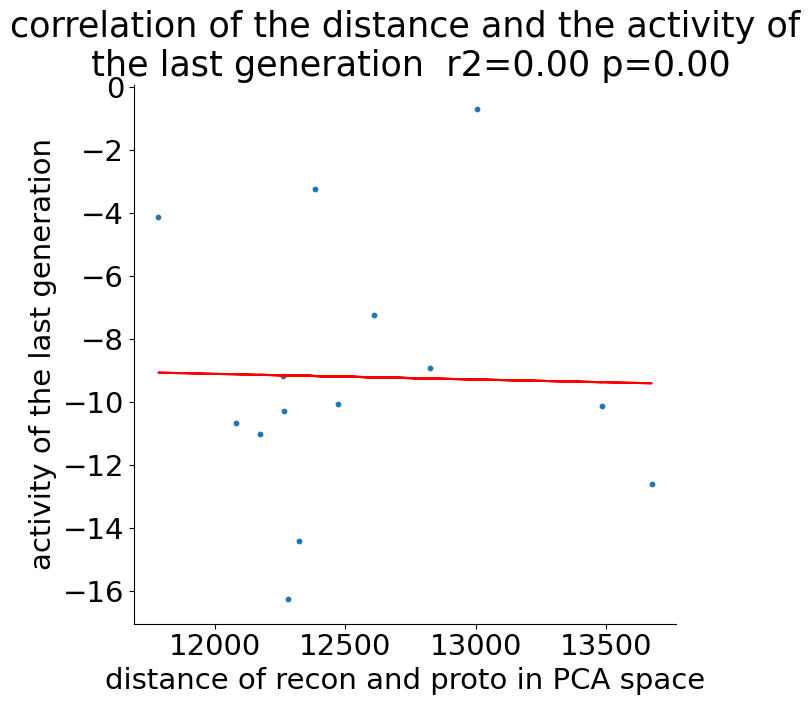

In [69]:
# let find the code for all last generations in PCA space
from sklearn.linear_model import LinearRegression

proto_last_gen_codes_in_PCA = PCA_score[units_proto_evol_gen_id_cat == num_gen - 1, :]
units_ids_last_gen_coresspond = units_proto_evol_unit_id_cat[units_proto_evol_gen_id_cat == num_gen - 1]
recon_last_code_in_PCA = recon_best_code_all_PC[num_gen - 1, :]
# find the distance of the proto_last_gen_codes_in_PCA and recon_last_code_in_PCA
dist = "MSE"
if dist == "MSE":
    dist_vec = np.mean((proto_last_gen_codes_in_PCA - recon_last_code_in_PCA)**2, axis=1)
elif dist == "cosine":
    from sklearn.metrics.pairwise import cosine_similarity
    dist_vec = np.mean(cosine_similarity(proto_last_gen_codes_in_PCA, recon_last_code_in_PCA.reshape(1, -1)), axis=1)
# let plot the histogram of the distance
act_of_last_gen = recon_act_mat[num_gen - 1, :num_of_units_to_cat]
# let get scatter plot of the distance and the activity of the last generation
plt.figure(figsize=(7, 7))
plt.scatter(dist_vec, act_of_last_gen, s=10)
plt.xlabel('distance of recon and proto in PCA space')
plt.ylabel('activity of the last generation')
# find the the linear regression of the distance and the activity of the last generation
reg = LinearRegression().fit(dist_vec.reshape(-1, 1), act_of_last_gen)
# get the the r2 and p value
r2, p = reg.score(dist_vec.reshape(-1, 1), act_of_last_gen), reg.score(dist_vec.reshape(-1, 1), act_of_last_gen)
# plot the linear regression
plt.plot(dist_vec, reg.predict(dist_vec.reshape(-1, 1)), color='r')
plt.title(f'correlation of the distance and the activity of\n the last generation  r2={r2:.2f} p={p:.2f}')



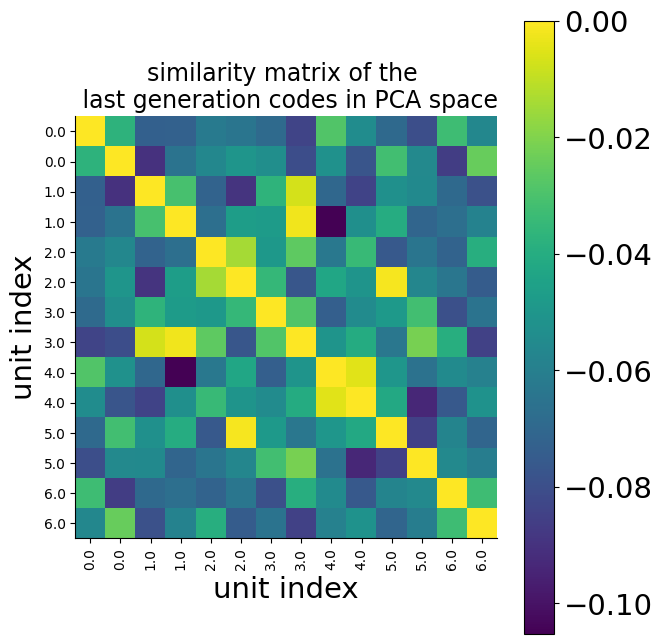

In [ ]:
# let see ther us a clustring in the similarity of the code come form same unit
# find siliarity matrix of proto_last_gen_codes_in_PCA using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(proto_last_gen_codes_in_PCA)
# let remve the diagonal
np.fill_diagonal(similarity_matrix, np.nan)
# let plot the similarity matrix
plt.figure(figsize=(7, 7))  
plt.imshow(similarity_matrix, cmap='viridis')
# set the x y tiks to the unit index 
plt.xticks(np.arange(num_of_units_to_cat), units_ids_last_gen_coresspond, rotation=90, fontsize=10)
plt.yticks(np.arange(num_of_units_to_cat), units_ids_last_gen_coresspond, fontsize=10)
plt.title('similarity matrix of the \n last generation codes in PCA space', fontsize=17)
plt.xlabel('unit index')
plt.ylabel('unit index')
plt.colorbar()
plt.tight_layout()

Text(0.5, 1.0, 'correlation of the distance and the activity of\n the last generation  r2=0.01 p=0.01')

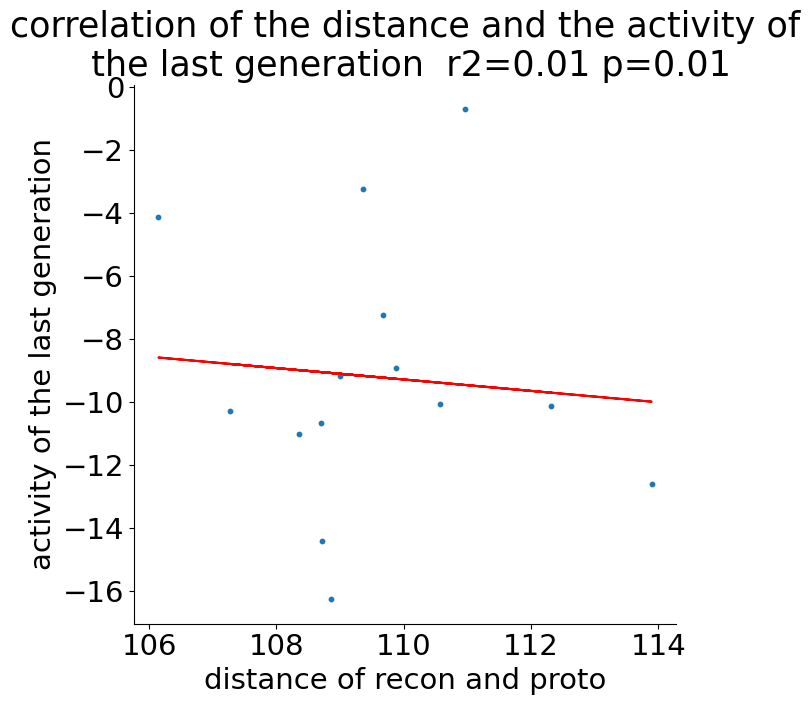

In [71]:
# let find the code for all last generations in full space
from sklearn.linear_model import LinearRegression

proto_last_gen_codes = units_proto_evol_codes_cat[units_proto_evol_gen_id_cat == num_gen - 1, :]
units_ids_last_gen_coresspond = units_proto_evol_unit_id_cat[units_proto_evol_gen_id_cat == num_gen - 1]
recon_last_code = recon_best_code_all[num_gen - 1, :]
# find the distance of the proto_last_gen_codes_in_PCA and recon_last_code_in_PCA
dist = "MSE"
if dist == "MSE":
    dist_vec = np.mean((proto_last_gen_codes - recon_last_code)**2, axis=1)
elif dist == "cosine":
    from sklearn.metrics.pairwise import cosine_similarity
    dist_vec = np.mean(cosine_similarity(proto_last_gen_codes, recon_last_code.reshape(1, -1)), axis=1)
# let plot the histogram of the distance
act_of_last_gen = recon_act_mat[num_gen - 1, :num_of_units_to_cat]
# let get scatter plot of the distance and the activity of the last generation
plt.figure(figsize=(7, 7))
plt.scatter(dist_vec, act_of_last_gen, s=10)
plt.xlabel('distance of recon and proto')
plt.ylabel('activity of the last generation')
# find the the linear regression of the distance and the activity of the last generation
reg = LinearRegression().fit(dist_vec.reshape(-1, 1), act_of_last_gen)
# get the the r2 and p value
r2, p = reg.score(dist_vec.reshape(-1, 1), act_of_last_gen), reg.score(dist_vec.reshape(-1, 1), act_of_last_gen)
# plot the linear regression
plt.plot(dist_vec, reg.predict(dist_vec.reshape(-1, 1)), color='r')
plt.title(f'correlation of the distance and the activity of\n the last generation  r2={r2:.2f} p={p:.2f}')

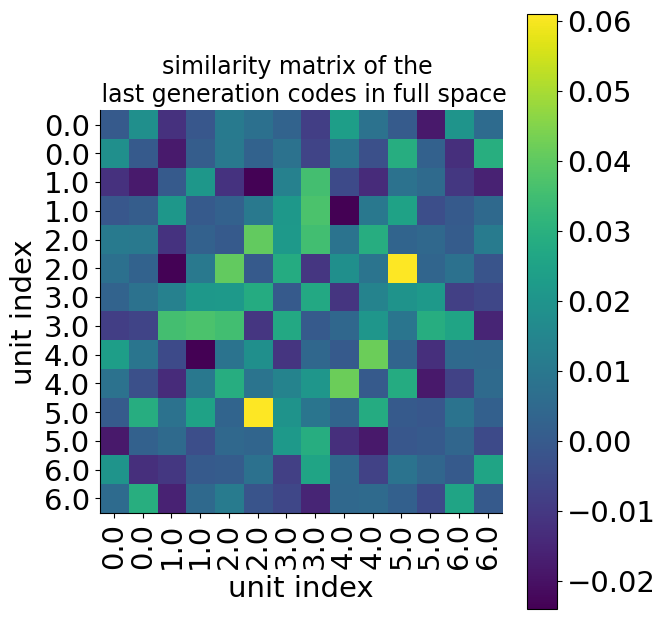

In [72]:
# let see ther us a clustring in the similarity of the code come form same unit
# find siliarity matrix of proto_last_gen_codes_in_PCA using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(proto_last_gen_codes)
# let remve the diagonal
np.fill_diagonal(similarity_matrix, 0)
# let plot the similarity matrix
plt.figure(figsize=(7, 7))  
plt.imshow(similarity_matrix, cmap='viridis')
# set the x y tiks to the unit index 
plt.xticks(np.arange(num_of_units_to_cat), units_ids_last_gen_coresspond, rotation=90)
plt.yticks(np.arange(num_of_units_to_cat), units_ids_last_gen_coresspond)
plt.title('similarity matrix of the \n last generation codes in full space', fontsize=17)
plt.xlabel('unit index')
plt.ylabel('unit index')
plt.colorbar()
plt.tight_layout()

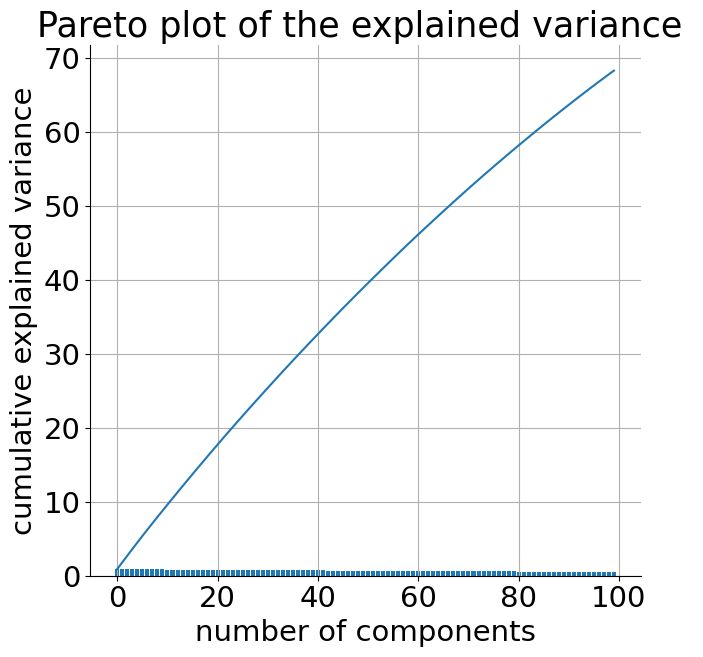

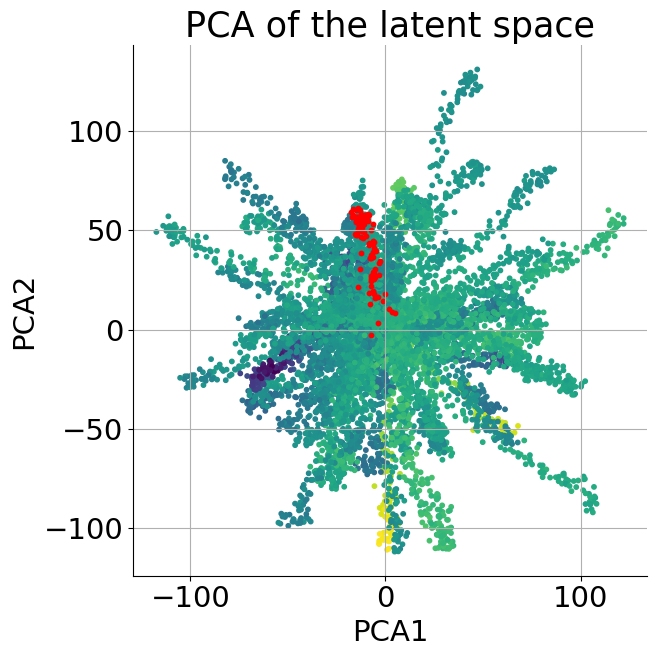

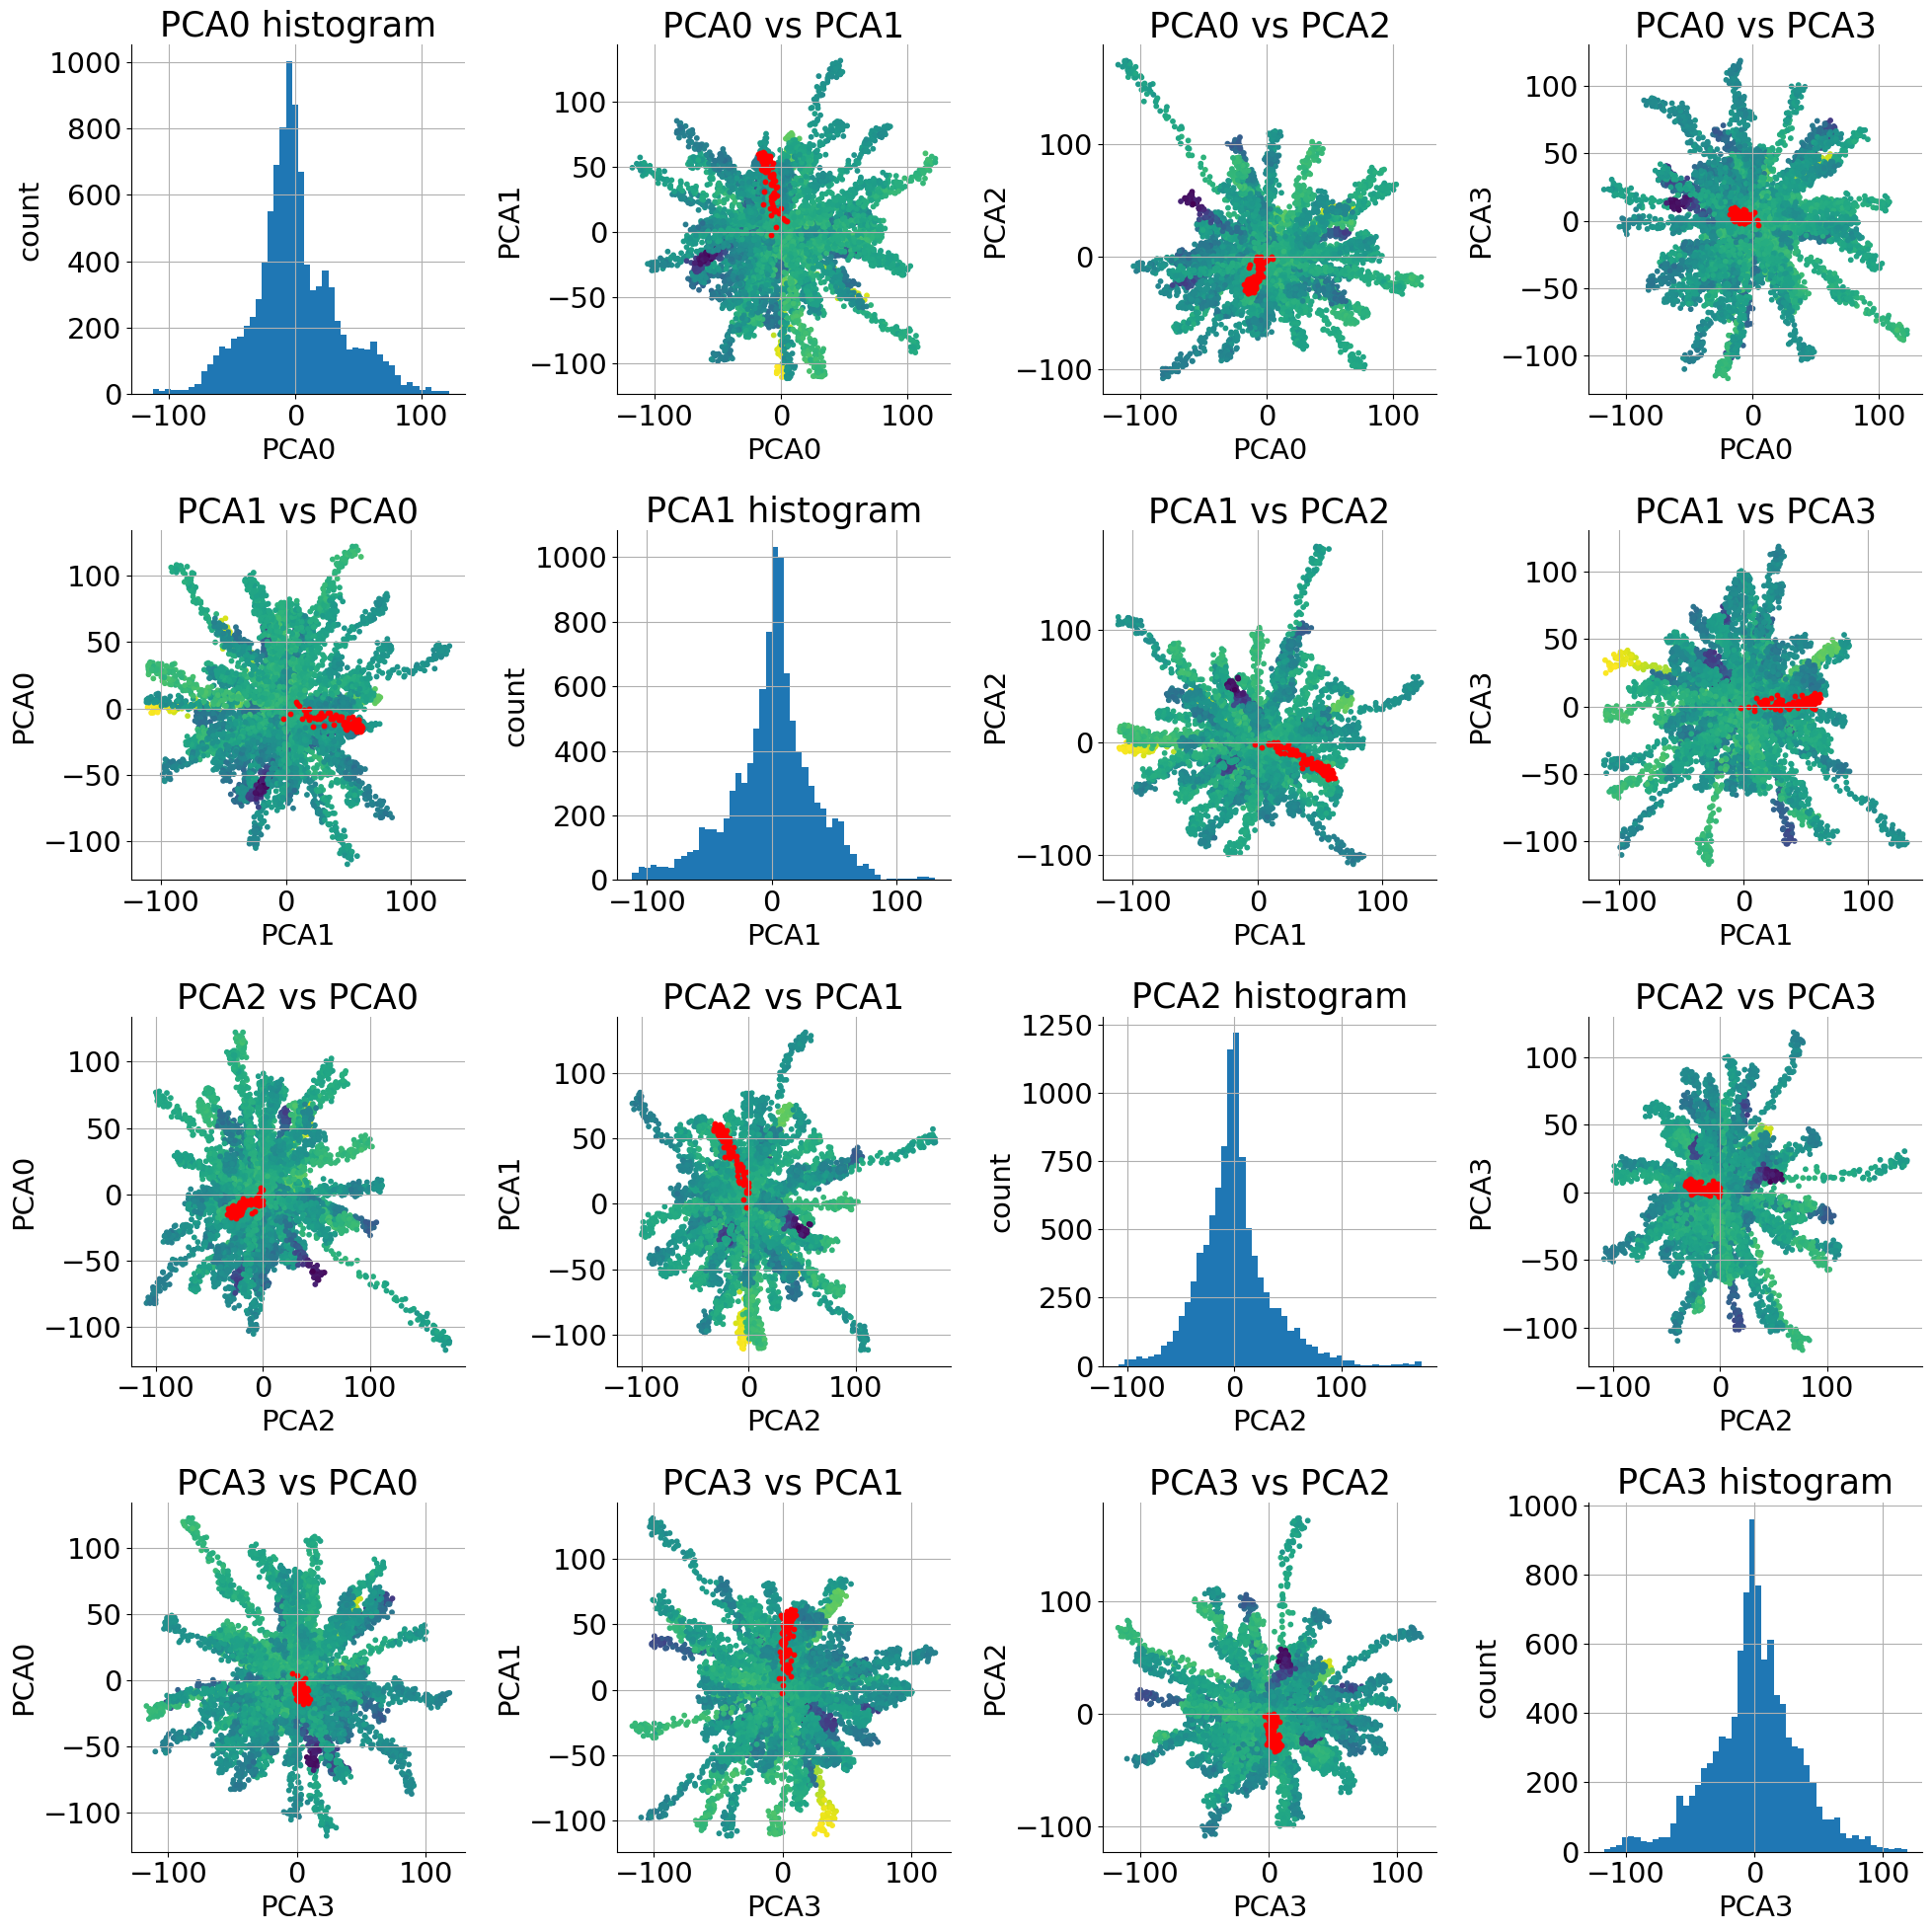

In [73]:
# let get PCA but concat the recon to the latent space
num_of_units_to_cat = 100
units_proto_evol_codes_cat = np.concatenate(units_proto_evol_codes[:num_of_units_to_cat], axis=0)
'''# let z score each unit codes before concatenating
units_proto_evol_codes_zscore = list()
for unit_code in units_proto_evol_codes[:num_of_units_to_cat]:
    # z score by scipy
    unit_code_zscore = stats.zscore(unit_code, axis=0)
    units_proto_evol_codes_zscore.append(unit_code_zscore)
units_proto_evol_codes_cat = np.concatenate(units_proto_evol_codes_zscore, axis=0)'''
units_proto_evol_unit_id_cat = np.concatenate(units_proto_evol_unit_id[:num_of_units_to_cat], axis=0)
units_proto_evol_gen_id_cat = np.concatenate(units_proto_evol_gen_id[:num_of_units_to_cat], axis=0)
units_proto_evol_act_mat_cat = np.concatenate(units_proto_evol_act_mat_list[:num_of_units_to_cat], axis=0)

# let concatenate the recon_best_code_all to the latent space
units_proto_evol_codes_cat = np.concatenate([units_proto_evol_codes_cat, recon_best_code_all], axis=0)
units_proto_evol_unit_id_cat = np.concatenate([units_proto_evol_unit_id_cat, np.ones(recon_best_code_all.shape[0]) * -1], axis=0)
units_proto_evol_gen_id_cat = np.concatenate([units_proto_evol_gen_id_cat, np.arange(recon_best_code_all.shape[0])], axis=0)
units_proto_evol_act_mat_cat = np.concatenate([units_proto_evol_act_mat_cat, recon_act_mat], axis=0)


n_components = num_of_units_to_cat
pca_latent_space = PCA(n_components=n_components)
PCA_score = pca_latent_space.fit_transform(units_proto_evol_codes_cat)
# let plot the pareto plot of the ecplained variance of the first 10 components
plt.figure(figsize=(7, 7))
plt.plot(np.cumsum(pca_latent_space.explained_variance_ratio_*100))
plt.bar(np.arange(n_components), pca_latent_space.explained_variance_ratio_*100)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Pareto plot of the explained variance ')
plt.grid()
plt.tight_layout()

# let plot the first 2 components of the PCA and give the color of the points based on the unit index
plt.figure(figsize=(7, 7))
selected_unit = 0
plt.scatter(PCA_score[units_proto_evol_unit_id_cat != -1, 0], PCA_score[units_proto_evol_unit_id_cat != -1,1], s=10, c=units_proto_evol_act_mat_cat[units_proto_evol_unit_id_cat != -1, selected_unit], cmap='viridis')
plt.scatter(PCA_score[units_proto_evol_unit_id_cat == -1, 0], PCA_score[units_proto_evol_unit_id_cat == -1,1], s=10, c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of the latent space')
plt.grid()
plt.tight_layout()
plt.show()

# let print girp of 4 first components
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
selected_unit = 0
for i in range(4):
    for j in range(4):
        if i != j:
            axs[i, j].scatter(PCA_score[units_proto_evol_unit_id_cat != -1, i], PCA_score[units_proto_evol_unit_id_cat != -1, j], s=10, c=units_proto_evol_act_mat_cat[units_proto_evol_unit_id_cat != -1, selected_unit], cmap='viridis')
            # add the reconstrction trajectory
            axs[i, j].scatter(PCA_score[units_proto_evol_unit_id_cat == -1, i], PCA_score[units_proto_evol_unit_id_cat == -1, j], s=10, c='red')
            axs[i, j].set_xlabel(f'PCA{i}')
            axs[i, j].set_ylabel(f'PCA{j}')
            axs[i, j].set_title(f'PCA{i} vs PCA{j}')
            axs[i, j].grid()
        else:
            # let plot the histogram of the component
            axs[i, j].hist(PCA_score[:, i], bins=50)
            axs[i, j].set_xlabel(f'PCA{i}')
            axs[i, j].set_ylabel('count')
            axs[i, j].set_title(f'PCA{i} histogram')
            axs[i, j].grid()
plt.tight_layout()

correlation of the distance and the activity of the last generation  r=0.02 p=0.86


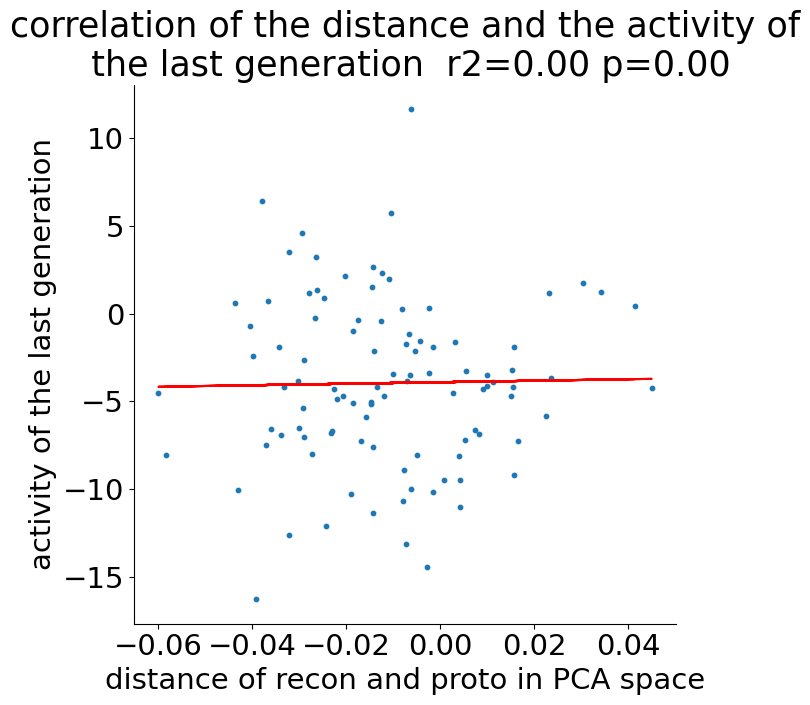

In [74]:
# let find the code for all last generations in PCA space
from sklearn.linear_model import LinearRegression

proto_last_gen_codes_in_PCA = PCA_score[(units_proto_evol_gen_id_cat == num_gen - 1) & (units_proto_evol_unit_id_cat != -1), :]
recon_last_code_in_PCA = PCA_score[(units_proto_evol_unit_id_cat == -1) & (units_proto_evol_gen_id_cat == num_gen - 1), :]
# find the distance of the proto_last_gen_codes_in_PCA and recon_last_code_in_PCA
dist = "cosine"
if dist == "MSE":
    dist_vec = np.mean((proto_last_gen_codes_in_PCA - recon_last_code_in_PCA)**2, axis=1)
elif dist == "cosine":
    from sklearn.metrics.pairwise import cosine_similarity
    dist_vec = np.mean(cosine_similarity(proto_last_gen_codes_in_PCA, recon_last_code_in_PCA.reshape(1, -1)), axis=1)
# let plot the histogram of the distance
act_of_last_gen = recon_act_mat[num_gen - 1, :num_of_units_to_cat]
# let get scatter plot of the distance and the activity of the last generation
plt.figure(figsize=(7, 7))
plt.scatter(dist_vec, act_of_last_gen, s=10)
plt.xlabel('distance of recon and proto in PCA space')
plt.ylabel('activity of the last generation')
# find the the linear regression of the distance and the activity of the last generation
reg = LinearRegression().fit(dist_vec.reshape(-1, 1), act_of_last_gen)
# get the the r2 and p value
r2, p = reg.score(dist_vec.reshape(-1, 1), act_of_last_gen), reg.score(dist_vec.reshape(-1, 1), act_of_last_gen)
# plot the linear regression
plt.plot(dist_vec, reg.predict(dist_vec.reshape(-1, 1)), color='r')
plt.title(f'correlation of the distance and the activity of\n the last generation  r2={r2:.2f} p={p:.2f}')
# let get the correlation of the distance and the activity of the last generation
from scipy.stats import pearsonr
r, p = pearsonr(dist_vec, act_of_last_gen)
print(f"correlation of the distance and the activity of the last generation  r={r:.2f} p={p:.2f}")
